### Аваиарейсы без потерь
Задача:
Порвести анализ авиарейсов из города Анапв в зимнее время за 2017 год и сделать вывод о том, от каких самых малоприбыльных рейсов мы можем отказаться.

**Прибыльность рейса** - это разница между доходом от продаж билетов и расходом на полёт.  
Для простоты возьмём такую оценку прибыльности:    
**общая стоимость билетов на рейс** - **расходы на топливо**, где <br>**расход на топливо** = **длительность полёта** * **расход в час** * **стомость топлива**.

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# ! pip install --user geopy
from geopy.distance import geodesic

In [145]:
data = pd.read_csv('anapa.csv')

In [146]:
data.head(5)

,flight_id,flight_no,scheduled_departure,scheduled_arrival,status,actual_departure,actual_arrival,duration,airport_code,airport_name,...,range,fare_conditions_b,fare_conditions_c,fare_conditions_e,total_tickets_b,total_amount_b,total_tickets_c,total_amount_c,total_tickets_e,total_amount_e
0,136119,PG0252,2017-01-03T10:05:00Z,2017-01-03T11:45:00Z,Arrived,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,101.0,SVO,Sheremetyevo International Airport,...,4200,12,NaN,118,11.0,402600.0,NaN,NaN,102.0,1250400.0
1,136120,PG0252,2017-02-24T10:05:00Z,2017-02-24T11:45:00Z,Arrived,2017-02-24T10:07:00Z,2017-02-24T11:46:00Z,99.0,SVO,Sheremetyevo International Airport,...,4200,12,NaN,118,11.0,402600.0,NaN,NaN,98.0,1202800.0
2,136122,PG0252,2017-01-08T10:05:00Z,2017-01-08T11:45:00Z,Arrived,2017-01-08T10:08:00Z,2017-01-08T11:48:00Z,100.0,SVO,Sheremetyevo International Airport,...,4200,12,NaN,118,10.0,366000.0,NaN,NaN,87.0,1065000.0
3,136130,PG0252,2017-02-13T10:05:00Z,2017-02-13T11:45:00Z,Arrived,2017-02-13T10:07:00Z,2017-02-13T11:46:00Z,99.0,SVO,Sheremetyevo International Airport,...,4200,12,NaN,118,10.0,366000.0,NaN,NaN,97.0,1190600.0
4,136131,PG0252,2017-01-28T10:05:00Z,2017-01-28T11:45:00Z,Arrived,2017-01-28T10:07:00Z,2017-01-28T11:46:00Z,99.0,SVO,Sheremetyevo International Airport,...,4200,12,NaN,118,12.0,439200.0,NaN,NaN,112.0,1373600.0


In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            193 non-null    int64  
 1   flight_no            193 non-null    object 
 2   scheduled_departure  193 non-null    object 
 3   scheduled_arrival    193 non-null    object 
 4   status               193 non-null    object 
 5   actual_departure     193 non-null    object 
 6   actual_arrival       193 non-null    object 
 7   duration             193 non-null    float64
 8   airport_code         193 non-null    object 
 9   airport_name         193 non-null    object 
 10  city                 193 non-null    object 
 11  longitude            193 non-null    float64
 12  latitude             193 non-null    float64
 13  aircraft_code        193 non-null    object 
 14  model                193 non-null    object 
 15  range                193 non-null    int

In [148]:
data.actual_arrival

0      2017-01-03T11:49:00Z
1      2017-02-24T11:46:00Z
2      2017-01-08T11:48:00Z
3      2017-02-13T11:46:00Z
4      2017-01-28T11:46:00Z
               ...         
188    2017-01-17T11:21:00Z
189    2016-12-13T11:16:00Z
190    2016-12-27T11:21:00Z
191    2017-01-03T11:15:00Z
192    2017-02-14T11:23:00Z
Name: actual_arrival, Length: 193, dtype: object

In [149]:
# приведём время к нормальному состоянию

def to_date(s):
    s = s.replace('T', ' ')
    s = s.replace('Z', '')
    #return datetime.strptime(s, '%Y-%m-%dT%H:%M:%SZ')
    return pd.to_datetime(s)


data['scheduled_departure'] = data.apply(lambda row:
                                         to_date(row['scheduled_departure']),
                                         axis=1)
data['scheduled_arrival'] = data.apply(lambda row:
                                       to_date(row['scheduled_arrival']),
                                       axis=1)
data['actual_departure'] = data.apply(lambda row:
                                      to_date(row['actual_departure']),
                                      axis=1)
data['actual_arrival'] = data.apply(lambda row:
                                    to_date(row['actual_arrival']),
                                    axis=1)
data['year_dep'] = data['actual_departure'].dt.year
data['month_dep'] = data['actual_departure'].dt.month
data['weekday'] = data.actual_departure.dt.weekday

Видим, что в классе "комфорт" нет ни мест (fare_conditions_c), ни купленных билетов (total_tickets_c) в данном датасете.   
А также есть пропуски в числе приобретённых билетов, всего 13 таких строк.   
Узнаем, что это за рейсы:

In [150]:
# предварительно заполним все пустые значения
def fill_null(x):
    ''' заполним пустые значения '''
    for i in x.columns:
        if x[i].dtype == object:
            x[i] = x[i].fillna('')
        else:
            x[i] = x[i].fillna(0)
    return x


data = fill_null(data)

In [151]:
# теперь посмотрим что это за такие интересные рейсы
data['total_tickets'] = data['total_tickets_b'] + \
    data['total_tickets_c'] + data['total_tickets_e']
data['total_amount'] = data['total_amount_b'] + \
    data['total_amount_c'] + data['total_amount_e']

In [152]:
data[data.total_tickets == 0]

,flight_id,flight_no,scheduled_departure,scheduled_arrival,status,actual_departure,actual_arrival,duration,airport_code,airport_name,...,total_amount_b,total_tickets_c,total_amount_c,total_tickets_e,total_amount_e,year_dep,month_dep,weekday,total_tickets,total_amount
180,136518,PG0194,2016-12-20 06:10:00,2016-12-20 11:15:00,Arrived,2016-12-20 06:13:00,2016-12-20 11:17:00,304.0,NOZ,Spichenkovo Airport,...,0.0,0.0,0.0,0.0,0.0,2016,12,1,0.0,0.0
181,136534,PG0194,2016-12-06 06:10:00,2016-12-06 11:15:00,Arrived,2016-12-06 06:13:00,2016-12-06 11:17:00,304.0,NOZ,Spichenkovo Airport,...,0.0,0.0,0.0,0.0,0.0,2016,12,1,0.0,0.0
182,136523,PG0194,2017-01-10 06:10:00,2017-01-10 11:15:00,Arrived,2017-01-10 06:14:00,2017-01-10 11:26:00,312.0,NOZ,Spichenkovo Airport,...,0.0,0.0,0.0,0.0,0.0,2017,1,1,0.0,0.0
183,136513,PG0194,2017-02-28 06:10:00,2017-02-28 11:15:00,Arrived,2017-02-28 06:13:00,2017-02-28 11:23:00,310.0,NOZ,Spichenkovo Airport,...,0.0,0.0,0.0,0.0,0.0,2017,2,1,0.0,0.0
184,136514,PG0194,2017-02-07 06:10:00,2017-02-07 11:15:00,Arrived,2017-02-07 06:14:00,2017-02-07 11:13:00,299.0,NOZ,Spichenkovo Airport,...,0.0,0.0,0.0,0.0,0.0,2017,2,1,0.0,0.0
185,136560,PG0194,2017-01-24 06:10:00,2017-01-24 11:15:00,Arrived,2017-01-24 06:13:00,2017-01-24 11:18:00,305.0,NOZ,Spichenkovo Airport,...,0.0,0.0,0.0,0.0,0.0,2017,1,1,0.0,0.0
186,136544,PG0194,2017-01-31 06:10:00,2017-01-31 11:15:00,Arrived,2017-01-31 06:10:00,2017-01-31 11:14:00,304.0,NOZ,Spichenkovo Airport,...,0.0,0.0,0.0,0.0,0.0,2017,1,1,0.0,0.0
187,136511,PG0194,2017-02-21 06:10:00,2017-02-21 11:15:00,Arrived,2017-02-21 06:15:00,2017-02-21 11:25:00,310.0,NOZ,Spichenkovo Airport,...,0.0,0.0,0.0,0.0,0.0,2017,2,1,0.0,0.0
188,136540,PG0194,2017-01-17 06:10:00,2017-01-17 11:15:00,Arrived,2017-01-17 06:14:00,2017-01-17 11:21:00,307.0,NOZ,Spichenkovo Airport,...,0.0,0.0,0.0,0.0,0.0,2017,1,1,0.0,0.0
189,136533,PG0194,2016-12-13 06:10:00,2016-12-13 11:15:00,Arrived,2016-12-13 06:13:00,2016-12-13 11:16:00,303.0,NOZ,Spichenkovo Airport,...,0.0,0.0,0.0,0.0,0.0,2016,12,1,0.0,0.0


Все эти рейсы направлялись в Новокузнецк в аэропорт NOZ   
**Аэропорт Спиченково** — _международный_ аэропорт федерального значения города Новокузнецка.   
Поэтому будем считать, что эти рейсы зафрахтованы на так называемые "чартеры" за границу и прибыльны.

In [153]:
# исключим эти рейсы из датасета
data = data[data.total_tickets != 0]

In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 179
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   flight_id            180 non-null    int64         
 1   flight_no            180 non-null    object        
 2   scheduled_departure  180 non-null    datetime64[ns]
 3   scheduled_arrival    180 non-null    datetime64[ns]
 4   status               180 non-null    object        
 5   actual_departure     180 non-null    datetime64[ns]
 6   actual_arrival       180 non-null    datetime64[ns]
 7   duration             180 non-null    float64       
 8   airport_code         180 non-null    object        
 9   airport_name         180 non-null    object        
 10  city                 180 non-null    object        
 11  longitude            180 non-null    float64       
 12  latitude             180 non-null    float64       
 13  aircraft_code        180 non-null  

In [155]:
# ранее было выявлено, что в данном датасете нет класса "Комфорт" поэтому избавимся от ненужных столбцов
data.drop(['fare_conditions_c'], inplace=True, axis=1)
data.drop(['total_tickets_c'], inplace=True, axis=1)
data.drop(['total_amount_c'], inplace=True, axis=1)

### дополним датасет

In [156]:
# расчитаем расстояние от Анапы до аэропорта назначения
# координаты аэропорта Анапы долгота:37.35 широта:45
anapa = (37.35, 45.0)


def getdistance(lon, lat):
    city = (lon, lat)
    return geodesic(anapa, city).km


data['distance'] = data.apply(lambda row:
                              getdistance(lon=row['longitude'],
                                          lat=row['latitude']),
                              axis=1)

In [157]:
# посчитаем скорость рейса (время включает рулёжку и сам полёт)
def getspeed(d, t):
    return d/t


data['speed'] = data.apply(lambda row:
                           getspeed(row['distance'],
                                    row['duration']),
                           axis=1)

In [158]:
# рассчитаем расход на топливо
# данные взяты с сайта https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm?id=7329
# и https://vpolete.online/pereletyi/rashod-topliva-raznyih-samoletov.html#i-2
def fuel_consumption(m):
    '''возвращаем расход топлива в кг за минуту'''
    if m == '733':  # Boeing 737-300
        return 2400/60  # 2,4 тыс. кг/ч;
    elif m == 'SU9':  # Sukhoi Superjet-100
        return 1700/60  # 1,7 тыс. кг/ч;
    else:
        return -1


def get_expence(y, m, model, duration):
    '''возвращаем затраты на топливо
    в зависимости от месяца, модели и времени рейса'''
    if y == 2016 and m == 12:
        price = 38.867
    elif y == 2017 and m == 1:
        price = 41.435
    elif y == 2017 and m == 2:
        price = 39.553
    elif y == 2017 and m == 12:
        price = 47101
    else:
        price = -1
    return price * fuel_consumption(model) * duration


data['expense'] = data.apply(lambda row:
                             get_expence(y=row['year_dep'],
                                         m=row['month_dep'],
                                         model=row['aircraft_code'],
                                         duration=row['duration']),
                             axis=1)

In [159]:
# посчитаем маржу
data['margin'] = data['total_amount'] - data['expense']

In [160]:
# посчитаем процент заполненности салона
data['filling'] = data['total_tickets'] * 100 / \
    (data['fare_conditions_b'] + data['fare_conditions_e'])

In [161]:
# посчитаем соотношение бизнес и эконом класса
data['bsns_to_ecnmy'] = data['fare_conditions_b'] / \
    data['fare_conditions_e'] * 100
data['bsns_to_ecnmy_tickets'] = data['total_tickets_b'] / \
    data['total_tickets_e'] * 100

In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 179
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   flight_id              180 non-null    int64         
 1   flight_no              180 non-null    object        
 2   scheduled_departure    180 non-null    datetime64[ns]
 3   scheduled_arrival      180 non-null    datetime64[ns]
 4   status                 180 non-null    object        
 5   actual_departure       180 non-null    datetime64[ns]
 6   actual_arrival         180 non-null    datetime64[ns]
 7   duration               180 non-null    float64       
 8   airport_code           180 non-null    object        
 9   airport_name           180 non-null    object        
 10  city                   180 non-null    object        
 11  longitude              180 non-null    float64       
 12  latitude               180 non-null    float64       
 13  aircr

In [163]:
display(data.airport_code.unique())
display(data.flight_no.unique())

array(['SVO', 'EGO'], dtype=object)

array(['PG0252', 'PG0480'], dtype=object)

получается, что в исследуемом датасете только два направления   
Москва и Белгород

In [164]:
# направление - Москва
df = data[data.flight_no == 'PG0252']

<AxesSubplot:>

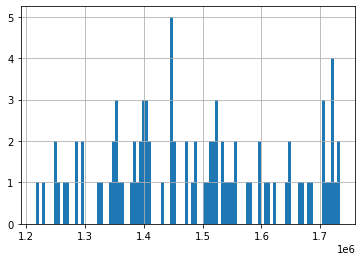

In [165]:
df.margin.hist(bins=100)

<AxesSubplot:>

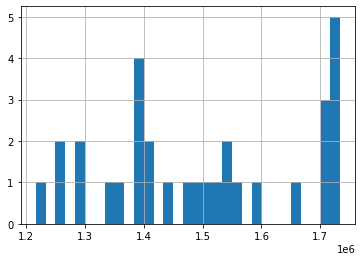

In [166]:
df[df.month_dep == 12].margin.hist(bins=31)

<AxesSubplot:>

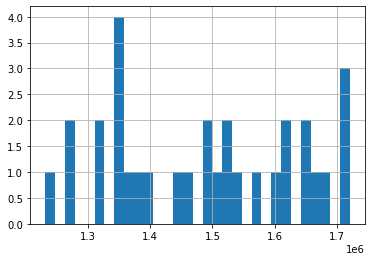

In [167]:
df[df.month_dep == 1].margin.hist(bins=31)

<AxesSubplot:>

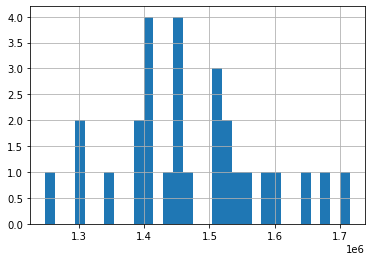

In [168]:
df[df.month_dep == 2].margin.hist(bins=31)

исследуем дни недели в которые была прибыль ниже первого квантиля

In [169]:
df_min = df[df.margin < df.margin.quantile(0.25)]
print('мин. маржа ')
display(df_min.weekday.value_counts())

мин. маржа 


6    6
5    4
3    4
2    4
1    2
0    2
4    1
Name: weekday, dtype: int64

In [170]:
df_min = df.query('margin < margin.quantile(0.25) & month_dep == 12')
print('декабрь 2016')
print('мин. маржа ')
display(df_min.weekday.value_counts())

декабрь 2016
мин. маржа 


5    3
6    2
3    1
2    1
1    1
Name: weekday, dtype: int64

In [171]:
df_min = df.query('margin < margin.quantile(0.25) & month_dep == 1')
print('январь 2017')
print('мин. маржа ')
display(df_min.weekday.value_counts())

январь 2017
мин. маржа 


6    3
2    2
0    2
5    1
4    1
3    1
1    1
Name: weekday, dtype: int64

In [172]:
df_min = df.query('margin < margin.quantile(0.25) & month_dep == 2')
print('февраль 2017')
print('мин. маржа ')
display(df_min.weekday.value_counts())

февраль 2017
мин. маржа 


3    2
2    1
6    1
Name: weekday, dtype: int64

In [173]:
df.weekday.unique()

array([1, 4, 6, 0, 5, 2, 3], dtype=int64)

для сравнения возьмем рейсы в дни, когда маржа была больше 3 квантиля

In [174]:
df_max = df[df.margin >= df.margin.quantile(0.75)]
print('макс. маржа ')
display(df_max.weekday.value_counts())

макс. маржа 


4    7
3    5
0    4
1    3
5    2
2    2
Name: weekday, dtype: int64

возьмём среду как наименьшее

посмотрим отличается ли средняя цена билетов между этими рейсами

In [175]:
avg_min_b = df.query('margin<margin.quantile(0.25) & weekday==6').total_amount_b.sum() / \
    df.query('margin<margin.quantile(0.25) & weekday==6').total_tickets_b.sum()
avg_max_b = df.query('margin>=margin.quantile(0.75) & weekday==2').total_amount_b.sum() / \
    df.query('margin>=margin.quantile(0.75) & weekday==2').total_tickets_b.sum()
avg_min_e = df.query('margin<margin.quantile(0.25) & weekday==6').total_amount_e.sum() / \
    df.query('margin<margin.quantile(0.25) & weekday==6').total_tickets_e.sum()
avg_max_e = df.query('margin>=margin.quantile(0.75) & weekday==2').total_amount_e.sum() / \
    df.query('margin>=margin.quantile(0.75) & weekday==2').total_tickets_e.sum()
print("Бизнес в воскресенье\n", avg_min_b)
print("Бизнес в среду\n", avg_max_b)
print("Эконом в воскресенье\n", avg_min_e)
print("Эконом в среду\n", avg_max_e)

Бизнес в воскресенье
 36600.0
Бизнес в среду
 36600.0
Эконом в воскресенье
 12250.457038391225
Эконом в среду
 12261.802575107296


цена не отличается

In [176]:
# заполненность рейсов
print("в понедельник", df.query(
    'margin<margin.quantile(0.25) & weekday==0').filling.mean())
print("во вторник", df.query(
    'margin<margin.quantile(0.25) & weekday==1').filling.mean())
print("в среду", df.query('margin<margin.quantile(0.25) & weekday==2').filling.mean())
print("в четверг", df.query(
    'margin<margin.quantile(0.25) & weekday==3').filling.mean())
print("в пятницу", df.query(
    'margin<margin.quantile(0.25) & weekday==4').filling.mean())
print("в субботу", df.query(
    'margin<margin.quantile(0.25) & weekday==5').filling.mean())
print("в воскресенье", df.query(
    'margin<margin.quantile(0.25) & weekday==6').filling.mean())
print("во все дни", df.filling.mean())

в понедельник 79.23076923076923
во вторник 80.76923076923077
в среду 77.88461538461539
в четверг 80.1923076923077
в пятницу 81.53846153846153
в субботу 75.57692307692308
в воскресенье 77.3076923076923
во все дни 87.26495726495727


In [177]:
print("во все понедельники", df.query('weekday==0').filling.mean())
print("во все вторники", df.query('weekday==1').filling.mean())
print("во все среды", df.query('weekday==2').filling.mean())
print("во все четверги", df.query('weekday==3').filling.mean())
print("во все пятницы", df.query('weekday==4').filling.mean())
print("во все субботы", df.query('weekday==5').filling.mean())
print("во все воскресенья", df.query('weekday==6').filling.mean())

во все понедельники 88.28402366863905
во все вторники 88.99408284023667
во все среды 85.96153846153845
во все четверги 89.28994082840238
во все пятницы 91.3609467455621
во все субботы 85.26627218934912
во все воскресенья 81.59763313609467


In [178]:
# средняя маржа по дням недели
print("во все понедельники", df.query('weekday==0').margin.mean())
print("во все вторники", df.query('weekday==1').margin.mean())
print("во все среды", df.query('weekday==2').margin.mean())
print("во все четверги", df.query('weekday==3').margin.mean())
print("во все пятницы", df.query('weekday==4').margin.mean())
print("во все субботы", df.query('weekday==5').margin.mean())
print("во все воскресенья", df.query('weekday==6').margin.mean())
print("во все дни", df.margin.mean())

во все понедельники 1499416.8215384616
во все вторники 1511997.7569230772
во все среды 1465179.1633333333
во все четверги 1521594.8523076922
во все пятницы 1565420.796923077
во все субботы 1464050.1538461538
во все воскресенья 1380356.6953846153
во все дни 1487100.3551111112


In [179]:
# общая маржа по дням недели
print("во все понедельники", df.query('weekday==0').margin.sum())
print("во все вторники", df.query('weekday==1').margin.sum())
print("во все среды", df.query('weekday==2').margin.sum())
print("во все четверги", df.query('weekday==3').margin.sum())
print("во все пятницы", df.query('weekday==4').margin.sum())
print("во все субботы", df.query('weekday==5').margin.sum())
print("во все воскресенья", df.query('weekday==6').margin.sum())

во все понедельники 19492418.68
во все вторники 19655970.84
во все среды 17582149.96
во все четверги 19780733.08
во все пятницы 20350470.36
во все субботы 19032652.0
во все воскресенья 17944637.04


Вывод: меньшей популярностью пользуются рейсы в среду и воскресенье

In [180]:
# получим рейсы с прибылью меньше 1 квантиля
_df = df.query('margin<margin.quantile(0.25)')[['flight_id', 'margin', 'weekday']]
_df.sort_values(['margin'], inplace=True)

In [181]:
_df.head(5)

,flight_id,margin,weekday
56,136352,1216932.00,5
81,136464,1232260.00,0
28,136250,1248005.88,2
69,136418,1252332.00,2
30,136253,1255441.36,5


In [182]:
Вывод: можно удалить рейс 136352

SyntaxError: invalid syntax (<ipython-input-182-87763fe63c0b>, line 1)

In [183]:
# направление - Белгород
df = data[data.flight_no == 'PG0480']

<AxesSubplot:>

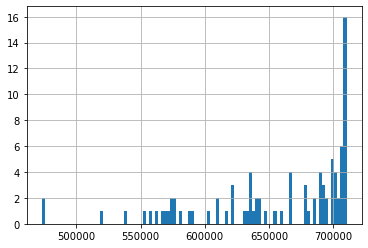

In [184]:
df.margin.hist(bins=100)

<AxesSubplot:>

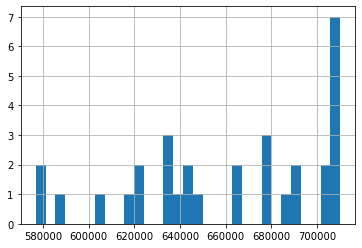

In [185]:
df[df.month_dep == 12].margin.hist(bins=31)

<AxesSubplot:>

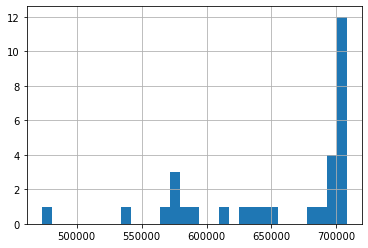

In [186]:
df[df.month_dep == 1].margin.hist(bins=31)

<AxesSubplot:>

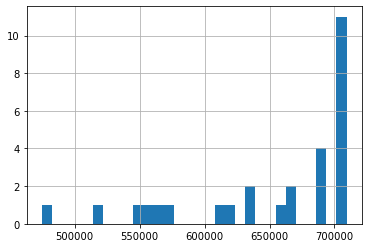

In [187]:
df[df.month_dep == 2].margin.hist(bins=30)

исследуем дни недели в которые была прибыль ниже первого квантиля

In [188]:
df_min = df[df.margin < df.margin.quantile(0.25)]
print('мин. маржа ')
display(df_min.weekday.value_counts())

мин. маржа 


6    4
5    4
4    4
1    4
0    4
3    3
Name: weekday, dtype: int64

In [189]:
df_min = df.query('margin < margin.quantile(0.25) & month_dep == 12')
print('декабрь 2016')
print('мин. маржа ')
display(df_min.weekday.value_counts())

декабрь 2016
мин. маржа 


6    2
5    2
4    2
0    1
Name: weekday, dtype: int64

In [190]:
df_min = df.query('margin < margin.quantile(0.25) & month_dep == 1')
print('январь 2017')
print('мин. маржа ')
display(df_min.weekday.value_counts())

январь 2017
мин. маржа 


0    3
1    2
6    1
5    1
4    1
3    1
Name: weekday, dtype: int64

In [191]:
df_min = df.query('margin < margin.quantile(0.25) & month_dep == 2')
print('февраль 2017')
print('мин. маржа ')
display(df_min.weekday.value_counts())

февраль 2017
мин. маржа 


3    2
1    2
6    1
5    1
4    1
Name: weekday, dtype: int64

посмотрим распределение по дням ниже среднего

In [192]:
df_min = df[df.margin < df.margin.mean()]
print('мин. маржа ')
display(df_min.weekday.value_counts())

мин. маржа 


6    8
5    7
1    6
0    6
4    5
3    4
2    1
Name: weekday, dtype: int64

In [193]:
df[df.margin >= df.margin.quantile(0.75)].weekday.value_counts()

3    4
2    4
1    4
6    3
5    3
4    3
0    2
Name: weekday, dtype: int64

In [194]:
avg_min_b = df.query('margin<margin.quantile(0.25)').total_amount_b.sum() / \
    df.query('margin<margin.quantile(0.25)').total_tickets_b.sum()
avg_max_b = df.query('margin>=margin.quantile(0.75)').total_amount_b.sum() / \
    df.query('margin>=margin.quantile(0.75)').total_tickets_b.sum()
avg_min_e = df.query('margin<margin.quantile(0.25)').total_amount_e.sum() / \
    df.query('margin<margin.quantile(0.25)').total_tickets_e.sum()
avg_max_e = df.query('margin>=margin.quantile(0.75)').total_amount_e.sum() / \
    df.query('margin>=margin.quantile(0.75)').total_tickets_e.sum()
print("Бизнес 1 квантиль\n", avg_min_b)
print("Бизнес 3 квантиль\n", avg_max_b)
print("Эконом 1 квантиль\n", avg_min_e)
print("Эконом 3 квантиль\n", avg_max_e)

Бизнес 1 квантиль
 18900.0
Бизнес 3 квантиль
 18900.0
Эконом 1 квантиль
 6334.254143646409
Эконом 3 квантиль
 6335.294117647059


цена не отличается

In [195]:
# заполненность рейсов
print("в понедельник", df.query(
    'margin<margin.quantile(0.25) & weekday==0').filling.mean())
print("во вторник", df.query(
    'margin<margin.quantile(0.25) & weekday==1').filling.mean())
print("в среду", df.query('margin<margin.quantile(0.25) & weekday==2').filling.mean())
print("в четверг", df.query(
    'margin<margin.quantile(0.25) & weekday==3').filling.mean())
print("в пятницу", df.query(
    'margin<margin.quantile(0.25) & weekday==4').filling.mean())
print("в субботу", df.query(
    'margin<margin.quantile(0.25) & weekday==5').filling.mean())
print("в воскресенье", df.query(
    'margin<margin.quantile(0.25) & weekday==6').filling.mean())

в понедельник 81.44329896907216
во вторник 83.76288659793813
в среду nan
в четверг 81.44329896907216
в пятницу 83.24742268041237
в субботу 82.47422680412372
в воскресенье 84.02061855670104


In [196]:
print("во все понедельники", df.query('weekday==0').filling.mean())
print("во все вторники", df.query('weekday==1').filling.mean())
print("во все среды", df.query('weekday==2').filling.mean())
print("во все четверги", df.query('weekday==3').filling.mean())
print("во все пятницы", df.query('weekday==4').filling.mean())
print("во все субботы", df.query('weekday==5').filling.mean())
print("во все воскресенья", df.query('weekday==6').filling.mean())

во все понедельники 91.59397303727201
во все вторники 92.94210943695481
во все среды 98.28178694158076
во все четверги 93.49722442505949
во все пятницы 92.38699444885012
во все субботы 92.54559873116575
во все воскресенья 91.91118160190325


средняя маржа по дням недели

In [197]:
print("во все понедельники", df.query('weekday==0').margin.mean())
print("во все вторники", df.query('weekday==1').margin.mean())
print("во все среды", df.query('weekday==2').margin.mean())
print("во все четверги", df.query('weekday==3').margin.mean())
print("во все пятницы", df.query('weekday==4').margin.mean())
print("во все субботы", df.query('weekday==5').margin.mean())
print("во все воскресенья", df.query('weekday==6').margin.mean())
print("во все дни", df.margin.mean())

во все понедельники 642478.2052564103
во все вторники 650542.7611538462
во все среды 696006.7968055557
во все четверги 657488.8264102564
во все пятницы 650669.7565384617
во все субботы 650112.8196153847
во все воскресенья 646148.2633333334
во все дни 655764.5531296293


In [198]:
# сумма маржи по дням недели
print("во все понедельники", df.query('weekday==0').margin.sum())
print("во все вторники", df.query('weekday==1').margin.sum())
print("во все среды", df.query('weekday==2').margin.sum())
print("во все четверги", df.query('weekday==3').margin.sum())
print("во все пятницы", df.query('weekday==4').margin.sum())
print("во все субботы", df.query('weekday==5').margin.sum())
print("во все воскресенья", df.query('weekday==6').margin.sum())

во все понедельники 8352216.668333334
во все вторники 8457055.895
во все среды 8352081.5616666665
во все четверги 8547354.743333332
во все пятницы 8458706.835
во все субботы 8451466.655000001
во все воскресенья 8399927.423333334


In [199]:
df.groupby('weekday').margin.sum()

weekday
0    8.352217e+06
1    8.457056e+06
2    8.352082e+06
3    8.547355e+06
4    8.458707e+06
5    8.451467e+06
6    8.399927e+06
Name: margin, dtype: float64

In [200]:
#_d = [0, 1, 2, 3, 4, 5, 6]
#_f = df.groupby('weekday').margin.sum()

In [201]:
#_df = pd.DataFrame(_f, _d)

In [202]:
#_df.margin.hist()

Вывод: меньшей популярностью пользуются рейсы в понедельник и среду

In [203]:
# получим рейсы с прибылью меньше 1 квантиля
_df = df.query('margin<margin.quantile(0.25)')[['flight_id', 'margin', 'weekday']]
_df.sort_values(['margin'], inplace=True)

In [204]:
_df.head(5)

,flight_id,margin,weekday
102,136642,473474.408333,0
144,136807,474966.583333,3
152,136844,519066.583333,1
164,136887,537674.408333,4
170,136922,551766.583333,5


Вывод: можно удалить рейсы 136642 и 136807

In [53]:
# data.to_csv('anapa_1.csv', index = False)